In [1]:
!gdown --id 1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0

C:\Users\ADMIN\anaconda3\envs\aio_exercise\lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0
From (redirected): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0&confirm=t&uuid=11870058-13af-47e2-a8f8-bef352e5c7cf
To: c:\Users\ADMIN\OneDrive - VNU-HCMUS\Old Laptop\AIO2024\Main Class\AIO-Exercise\Module_6\Week_2_Advanced_CNN\img_cls_weather_dataset.zip

  0%|          | 0.00/613M [00:00<?, ?B/s]
  0%|          | 524k/613M [00:00<11:35, 880kB/s]
  0%|          | 1.05M/613M [00:00<06:59, 1.46MB/s]
  0%|          | 1.57M/613M [00:00<04:59, 2.04MB/s]
  0%|          | 2.62M/613M [00:01<03:06, 3.28MB/s]
  1%|          | 3.15M/613M [00:01<03:07, 3.24MB/s]
  1%|          | 3.67M/613M [00:01<03:08, 3.23MB/s]
  1%|          | 4.19M/613M [00

In [2]:
import zipfile
import os

zip_file_path = "./img_cls_weather_dataset.zip"
extract_to_path = "./"

# Ensure the extraction folder exists
os.makedirs(extract_to_path, exist_ok=True)

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Files extracted to: {extract_to_path}")

Files extracted to: ./


### Import libraries

In [40]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

### Set seed

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed = 59
set_seed(seed)

### Read dataset

In [41]:
root_dir = 'weather-dataset/dataset'
classes = {
    label_idx: class_name for label_idx, class_name in enumerate(sorted(os.listdir(root_dir)))
}

img_paths = []
labels = []
for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)

In [42]:
classes

{0: 'dew',
 1: 'fogsmog',
 2: 'frost',
 3: 'glaze',
 4: 'hail',
 5: 'lightning',
 6: 'rain',
 7: 'rainbow',
 8: 'rime',
 9: 'sandstorm',
 10: 'snow'}

### Train, test, split

In [43]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

### Create Weather Dataset Class

In [44]:
class WeatherDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB') # use PIL cauz in future PIL will be use more
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

### Image Processing

In [45]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3] # if img has alpha channel (A in RGBA), it will be remove
    img = torch.tensor(img).permute(2, 0, 1).float()
    normalized_img = img / 255.0

    return normalized_img

### Create Dataloader

In [46]:
train_dataset = WeatherDataset(
    X_train, y_train,
    transform=transform
)
val_dataset = WeatherDataset(
    X_val, y_val,
    transform=transform
)
test_dataset = WeatherDataset(
    X_test, y_test,
    transform=transform
)

In [47]:
train_batch_size = 512
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

Feature batch shape: torch.Size([512, 3, 224, 224])
Labels batch shape: torch.Size([512])


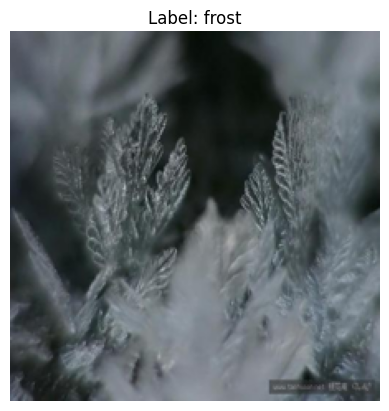

In [48]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].permute(1, 2, 0)
label = train_labels[0].item()
plt.imshow(img)
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

### ResNet Model

In [49]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # Main flow
        self.conv1 = nn.Conv2d(in_channels, out_channels, 
                               kernel_size=3, stride=stride, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        # skip connection
        # If stride=1 and in_channels=out_channels, shortcut is identity
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            # Use 1x1 convolution to match spatial dimensions or channel count (Bottleneck RB)
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = x.clone() # keep x

        # Main branch: conv1 -> BN1 -> ReLU -> conv2 -> BN2
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)

        # Add the shortcut to the residual mapping
        x += self.downsample(shortcut)
        x = self.relu(x)
        return x

ResidualBlock helps NN learn _residual mapping_ instead of all mapping.
$$y = F(x) + x$$
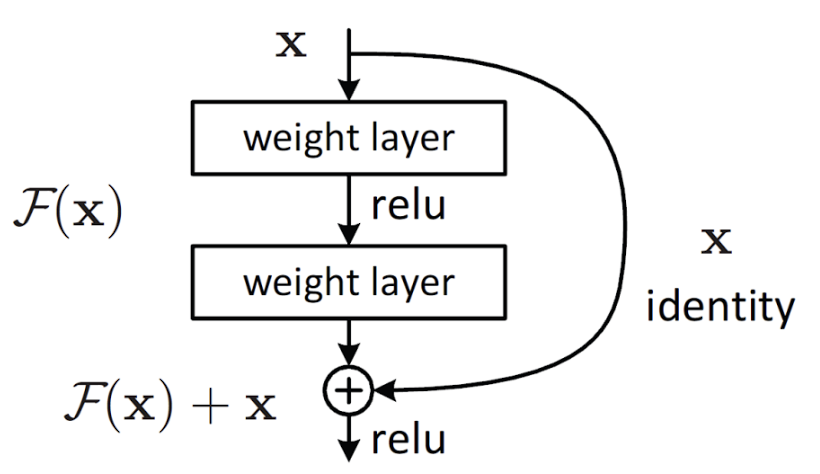

In [50]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)

        # Global average pooling reduces feature maps to 1x1
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(512, n_classes)

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []

        # First block: may reduce spatial size or change channel count
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)

        # Subsequent blocks: no spatial size reduction (stride=1)
        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride = 1)
            blocks.append(block)
        
        block_sequential  = nn.Sequential(*blocks)
        return block_sequential

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [51]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2, 2, 2, 2],
    n_classes=n_classes
).to(device)

### Training

In [52]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [53]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(
            f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

In [54]:
lr = 1e-2
epochs = 25
momentum = 0.9
w_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=w_decay)

In [55]:
train_losses, val_losses = fit(model, train_loader, val_loader, criterion, optimizer, device, epochs)

EPOCH 1:	Train loss: 1.7911	Val loss: 2.4876
EPOCH 2:	Train loss: 1.2170	Val loss: 4.6821
EPOCH 3:	Train loss: 1.0761	Val loss: 4.8934
EPOCH 4:	Train loss: 0.9861	Val loss: 1.5651
EPOCH 5:	Train loss: 0.8970	Val loss: 2.3637
EPOCH 6:	Train loss: 0.8225	Val loss: 1.5635
EPOCH 7:	Train loss: 0.7334	Val loss: 1.8848
EPOCH 8:	Train loss: 0.6792	Val loss: 2.8098
EPOCH 9:	Train loss: 0.6178	Val loss: 1.2137
EPOCH 10:	Train loss: 0.5887	Val loss: 1.6401
EPOCH 11:	Train loss: 0.5253	Val loss: 1.3038
EPOCH 12:	Train loss: 0.4704	Val loss: 2.0166
EPOCH 13:	Train loss: 0.3789	Val loss: 1.2666
EPOCH 14:	Train loss: 0.3028	Val loss: 1.9596
EPOCH 15:	Train loss: 0.2383	Val loss: 0.9532


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

### Evaluation

In [ ]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)